##### sentences_kopie_3 -> Mischung aus Zahlen und Sätze aus IAM Datensatz
##### sentences_kopie_2 -> Mischung aus Zahlen aus dem Bafög Antrag Beispielweise Geburtsdatum, Föderungsnummer usw


In [52]:
file_path ="C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/sentences_kopie_3.txt"
num_lines = 20

with open(file_path, "r") as file:
    for i in range(num_lines):
        line = file.readline()
        print(line.strip())


#--- sentences_kopie_3.txt -----------------------------------------------------------#
#
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     z01-001-01  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     292             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     182 19 0 0 -> bounding box around for this part of the sentence
#z01-001 file , image z01-001-01,02,03,04.....
z01-001-01 0 ok 182 19 0 0 292

In [2]:
file_path ="C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/sentences_kopie_2.txt"
num_lines = 20

with open(file_path, "r") as file:
    for i in range(num_lines):
        line = file.readline()
        print(line.strip())


#--- sentences_kopie_2.txt -----------------------------------------------------------#
#
#
# format: a01-000u-s0-00 0 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     z01-001-01  -> sentence/line id for form a01-000u
#     0               -> sentence number within this form
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            er: segmentation of line has one or more errors
#
#                        warning: if a sentence starts or ends in the middle of
#                                 a line which is not correctly segmeted, a
#                                 correct extraction of the sentence can fail.
#
#     292             -> graylevel to binarize line
#     19              -> number of components for this part of the sentence
#     182 19 0 0 -> bounding box around for this part of the sentence
#z01-001 file , image z01-001-01,02,03,04.....
z01-001-01 0 ok 182 19 0 0 292

In [4]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input, layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

###### entweder nutzt man sentences_kopie_3 für Zahlen und Sätze aus IAM oder 
###### sentences_kopie_2 für nur Zahlen aus Bafög Antrag

In [5]:
base_path =  "C:/Users/Anwender/Downloads/TI_Projekt/handwritting_IAM/data/"
words_list = []

words = open(f"{base_path}/sentences_kopie_3.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

##### Teile Datensatz in Training test und validation

In [6]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 548
Total validation samples: 30
Total test samples: 31


###### String "lines_4" ist für Combo aus Zahlen und Sätze 
######  String "lines_3" ist für nur Zahlen aus Bafög

In [7]:

base_image_path = os.path.join(base_path, "lines_4")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

      
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [8]:

train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  61
Vocab size:  72


['team|to|negotiate|terms|for|joining|the|Common|Market|.',
 'including|a|compulsory|savings|scheme|which|the',
 'yesterday|.',
 'Instead|,|the|kings|will|remain|in|London',
 '4|5|6|4|3|2|1|2|3|2|1|2|3|4|6',
 'Person_Geburtstag|0|1|0|6|1|9|9|9',
 '1|0|1|0|1|9|9|0',
 '5|3|7|1|0',
 'African|nationalists|.',
 '2|5|3|1|9']

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE


char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)


num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [11]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

   
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

   
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

###### EfficientNet födert Bild Große in der Breite von midenstens 2048 Höhe ist frei einstellbar

In [12]:
batch_size = 64
padding_token = 99
image_width = 2048
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [13]:
# Teile der Datensatz
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

###### Visualisierung von Beispiel Bilder und Labels

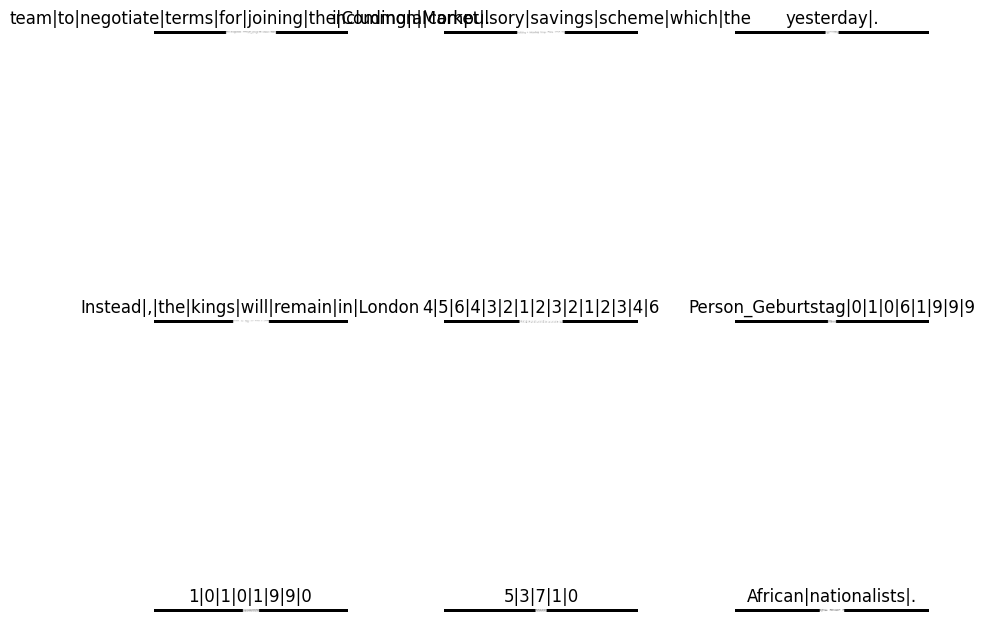

In [14]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]


    _, ax = plt.subplots(3, 3, figsize=(10, 10))  

    for i in range(9):  
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 3, i % 3].imshow(img, cmap="gray")
        ax[i // 3, i % 3].set_title(label)
        ax[i // 3, i % 3].axis("off")

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

###### CTC Layer für die Loss Berechnung 

In [15]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [16]:


def build_model():
   
    efficientnet_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_width, image_height, 3))
    


    for layer in efficientnet_model.layers:
        layer.trainable = False
    
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))
    
    # Create a 3-channel input by repeating the single channel
    input_expanded = Concatenate()([input_img, input_img, input_img])
    
    # Connect the EfficientNet base model
    x = efficientnet_model(input_expanded)
    
    # Get the output shape of the EfficientNet model
    efficientnet_output_shape = efficientnet_model.layers[-1].output_shape[1:]
    
    # Reshape accordingly before passing the output to the RNN part of the model.
    x = keras.layers.Reshape(target_shape=(int(efficientnet_output_shape[0]), -1), name="reshape")(x)
    
    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.GRU(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.GRU(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()




Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 2048, 32, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 2048, 32, 3)          0         ['image[0][0]',               
                                                                     'image[0][0]',               
                                                                     'image[0][0]']               
                                                                                                  
 efficientnetb0 (Functional  (None, 64, 1, 1280)          4049571   ['concatenate[0][0]']         
 )                                                                         

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

###### compute the edit distance between the predicted text sequences and the ground truth labels

In [18]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)



###### Speicher jede Weights aus dem Training
###### Early stoping Anwendung

In [19]:
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


epochs = 50 

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edbit_distance_callback = EditDistanceCallback(prediction_model)
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Create a directory to store the weights
weights_dir = "saved_weights_2"
os.makedirs(weights_dir, exist_ok=True)

# Define the ModelCheckpoint callback
checkpoint_path = os.path.join(weights_dir, "weights_epoch_{epoch:02d}.h5")
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

edit_distance_callback = EditDistanceCallback(prediction_model)
callbacks=[edit_distance_callback, early_stopping, checkpoint_callback],

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    initial_epoch=0, 
    callbacks=callbacks,
)

Epoch 1/50
1/1 [==============================] - 7s 7s/steploss: 126.67
Mean edit distance for epoch 1: 61.0000

Epoch 1: saving model to saved_weights_2\weights_epoch_01.h5
9/9 [==============================] - 65s 5s/step - loss: 126.6766 - val_loss: 102.1503
Epoch 2/50
1/1 [==============================] - 1s 1s/steploss: 99.13
Mean edit distance for epoch 2: 61.0000

Epoch 2: saving model to saved_weights_2\weights_epoch_02.h5
9/9 [==============================] - 25s 3s/step - loss: 99.1323 - val_loss: 98.8338
Epoch 3/50
1/1 [==============================] - 1s 1s/steploss: 97.03
Mean edit distance for epoch 3: 61.0000

Epoch 3: saving model to saved_weights_2\weights_epoch_03.h5
9/9 [==============================] - 26s 3s/step - loss: 97.0365 - val_loss: 98.0530
Epoch 4/50
1/1 [==============================] - 1s 1s/steploss: 96.17
Mean edit distance for epoch 4: 61.0000

Epoch 4: saving model to saved_weights_2\weights_epoch_04.h5
9/9 [==============================] - 2

###### Plot aus Training von EfficientNet und LSTM Layers aus nur Zahlen aus Bafög

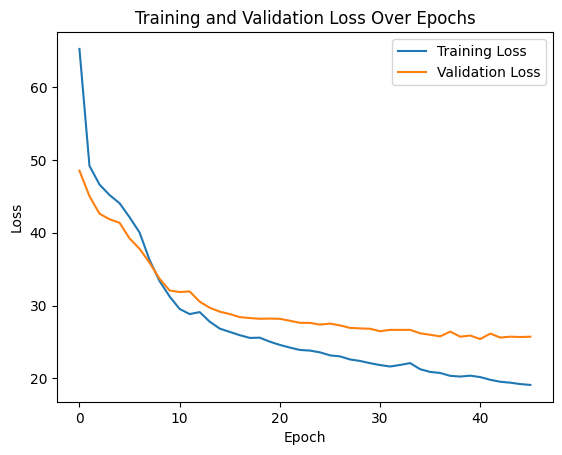

In [44]:
#numbers only effinet und lstm

# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


###### Plot aus Training von EfficientNet und GRU Layers trainiert mit nur Zahlen aus Bafög 

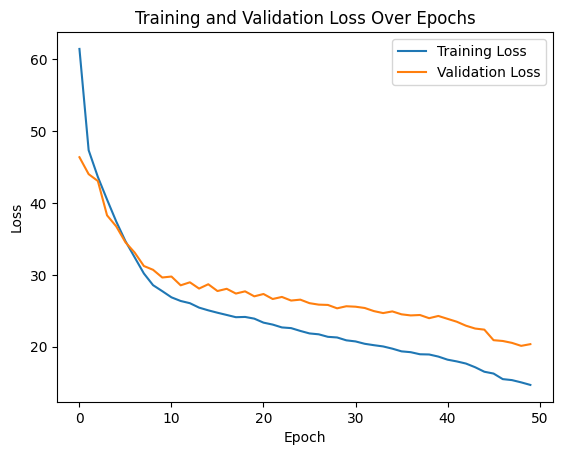

In [50]:
# mit gru and effiecnet numbers only 
# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

###### EffiecinetNet und LSTM Training aus BAfög und Sätze von IAM Datensatz

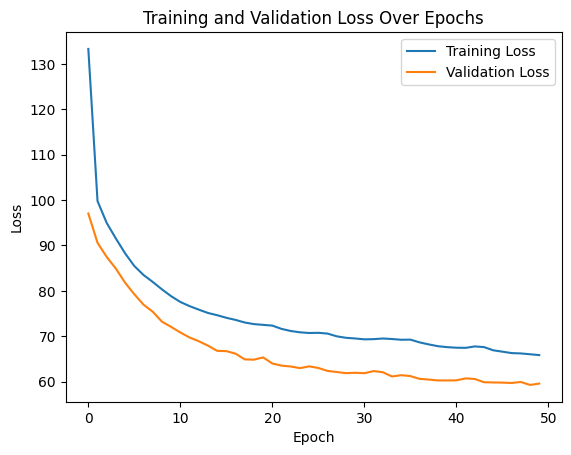

In [68]:
#numbers and sentences IAM effinet und lstm

# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


###### EffiecinetNet und GRU Training aus BAfög und Sätze von IAM Datensatz

In [ ]:
#numbers and sentences IAM effinet und GRU

# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


###### Visualisierung der Prediction aus nur Zahlen von Bafög efficientnet und  LSTM als Model

1/1 [==============================] - 0s 301ms/step


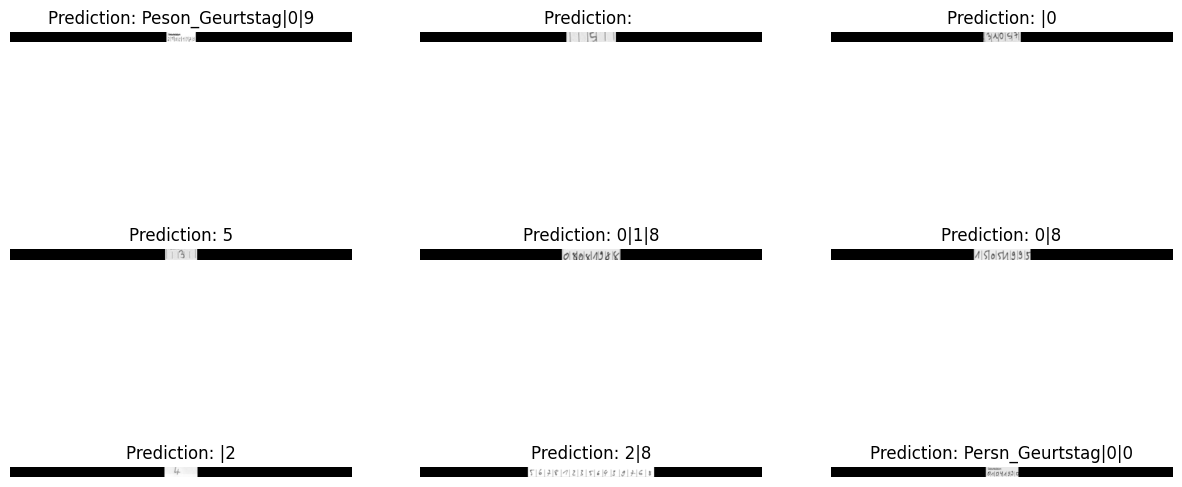

In [45]:
# A utility function to decode the output of the network.
#effienet und lstm numbers only 
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    num_images = batch_images.shape[0]

    # Calculate the number of rows and columns in the grid
    num_rows = 3
    num_cols = 3

    _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(min(num_rows * num_cols, num_images)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
        ax[i // num_cols, i % num_cols].set_title(title)
        ax[i // num_cols, i % num_cols].axis("off")

    # Hide empty subplots if there are fewer images than expected
    for j in range(num_images, num_rows * num_cols):
        ax[j // num_cols, j % num_cols].axis("off")

plt.show()


Visualisierung der Datensatz aus nur Zahlen efficientnet und  gru als Model

1/1 [==============================] - 0s 497ms/step


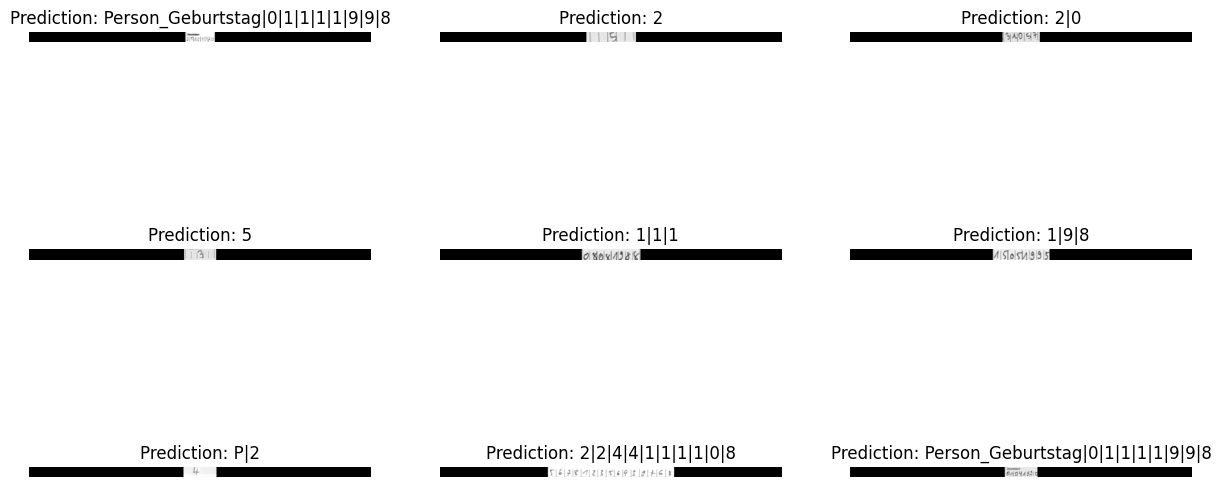

In [51]:
# A utility function to decode the output of the network.
#efficientnet and gru numbers only 
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    num_images = batch_images.shape[0]

    # Calculate the number of rows and columns in the grid
    num_rows = 3
    num_cols = 3

    _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(min(num_rows * num_cols, num_images)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
        ax[i // num_cols, i % num_cols].set_title(title)
        ax[i // num_cols, i % num_cols].axis("off")

    # Hide empty subplots if there are fewer images than expected
    for j in range(num_images, num_rows * num_cols):
        ax[j // num_cols, j % num_cols].axis("off")

plt.show()


Visualisierung aus Training mit efficientnet und  lstm Zahlen and iAM Datensatz

1/1 [==============================] - 2s 2s/step


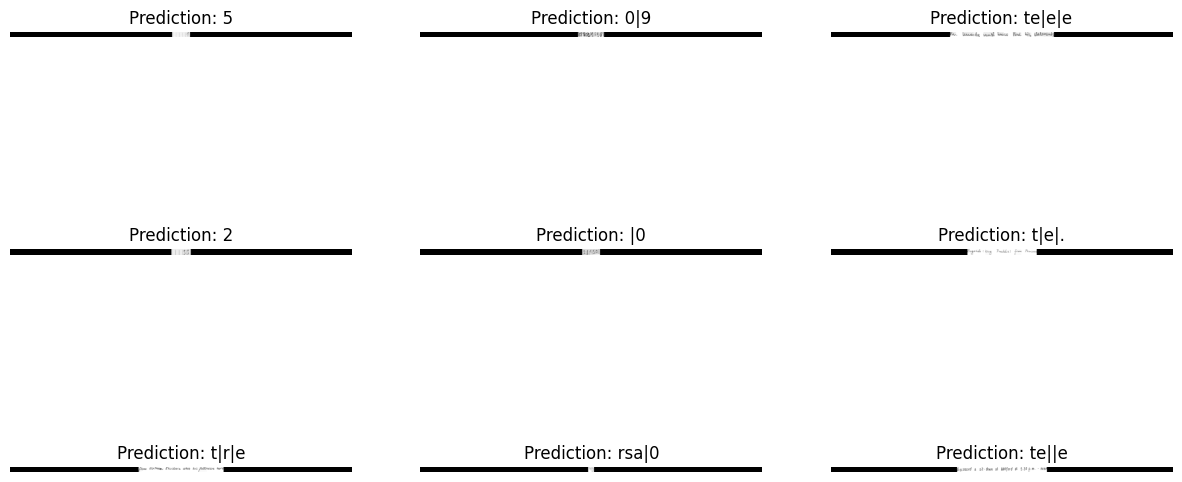

In [69]:
# A utility function to decode the output of the network.
#efficientnet and lstm numbers and iAM 
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    num_images = batch_images.shape[0]

    # Calculate the number of rows and columns in the grid
    num_rows = 3
    num_cols = 3

    _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(min(num_rows * num_cols, num_images)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
        ax[i // num_cols, i % num_cols].set_title(title)
        ax[i // num_cols, i % num_cols].axis("off")

    # Hide empty subplots if there are fewer images than expected
    for j in range(num_images, num_rows * num_cols):
        ax[j // num_cols, j % num_cols].axis("off")

plt.show()


Visualisierung der Predictions mit model efficientnet and GRU, iAM Datensatz und Zahlen aus Bafäg 

In [ ]:
# A utility function to decode the output of the network.
#efficientnet and GRU numbers and iAM 
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    num_images = batch_images.shape[0]

    # Calculate the number of rows and columns in the grid
    num_rows = 3
    num_cols = 3

    _, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(min(num_rows * num_cols, num_images)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
        ax[i // num_cols, i % num_cols].set_title(title)
        ax[i // num_cols, i % num_cols].axis("off")

    # Hide empty subplots if there are fewer images than expected
    for j in range(num_images, num_rows * num_cols):
        ax[j // num_cols, j % num_cols].axis("off")

plt.show()
